# artifact detection

In [1]:
import os
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

In [2]:
ssp_projectors = raw.info['projs']
raw.del_proj()

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

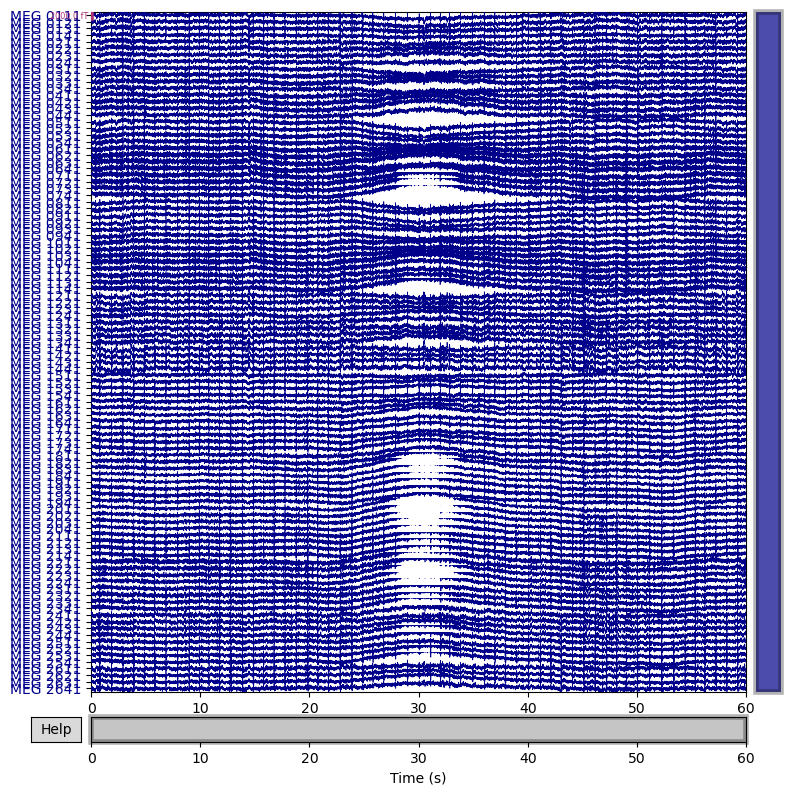

In [4]:
# low-frequency drifts

mag_channels = mne.pick_types(raw.info, meg='mag')
raw.plot(duration=60, order=mag_channels, n_channels=len(mag_channels),
         remove_dc=False);

# power line noise

In [6]:
fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True);
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.426 (s)


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


# heartbeat (ECG)

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Using data from preloaded Raw for 59 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata

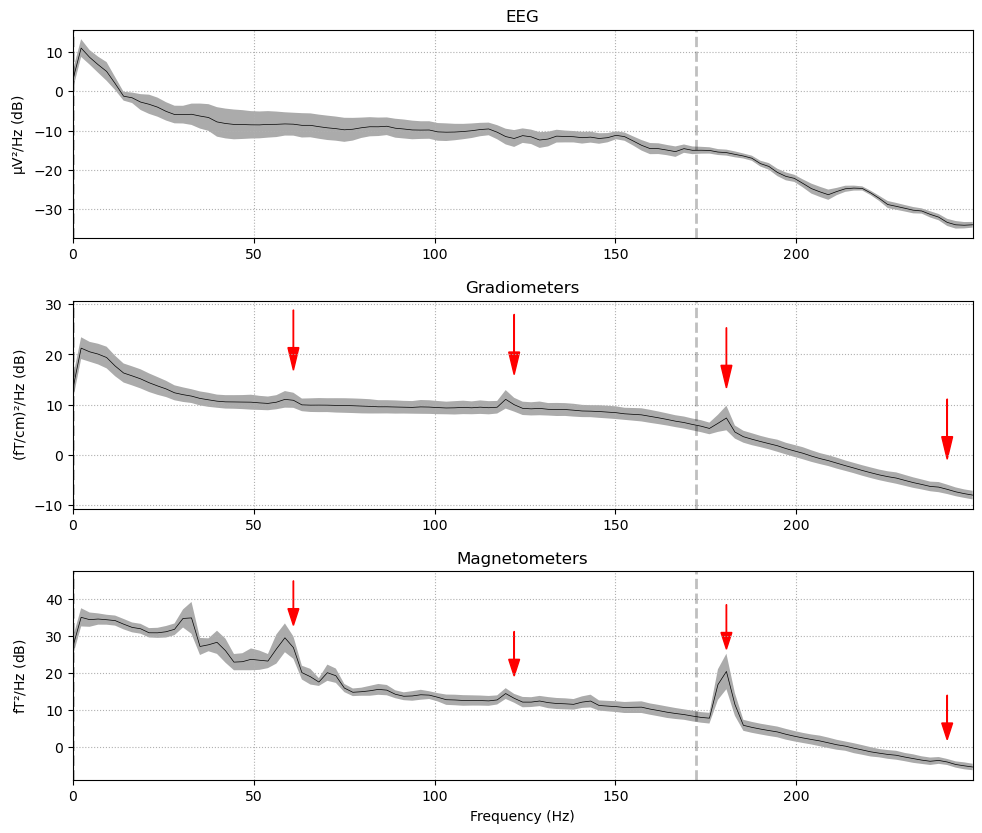

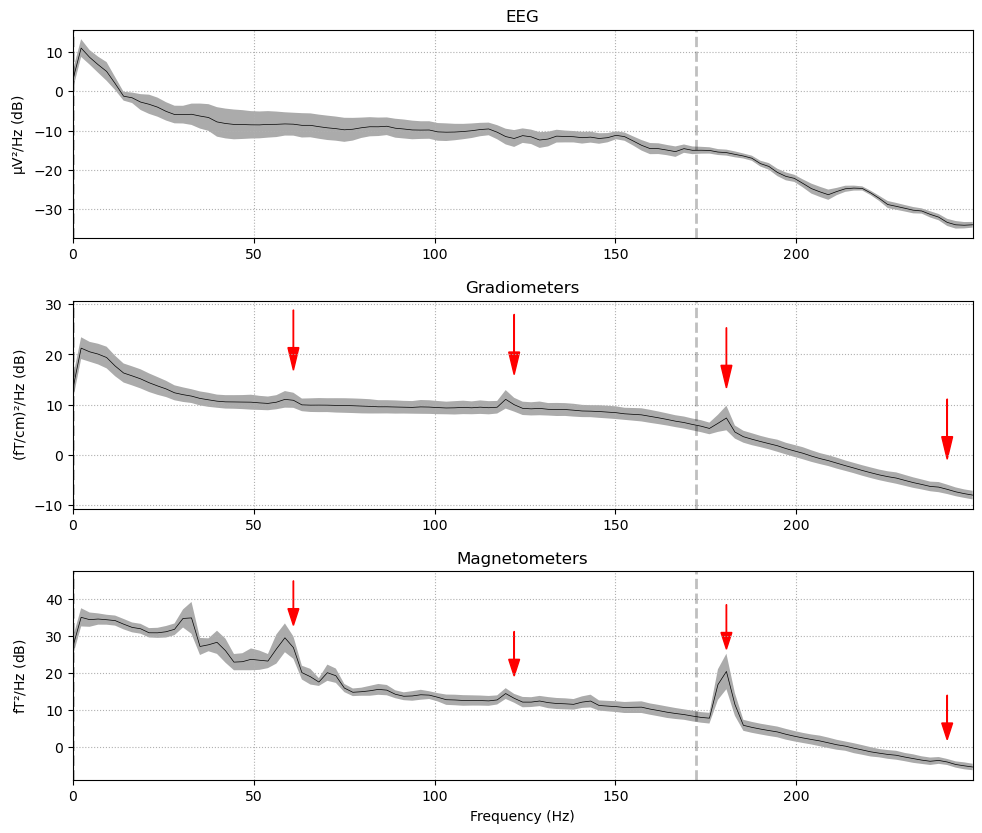

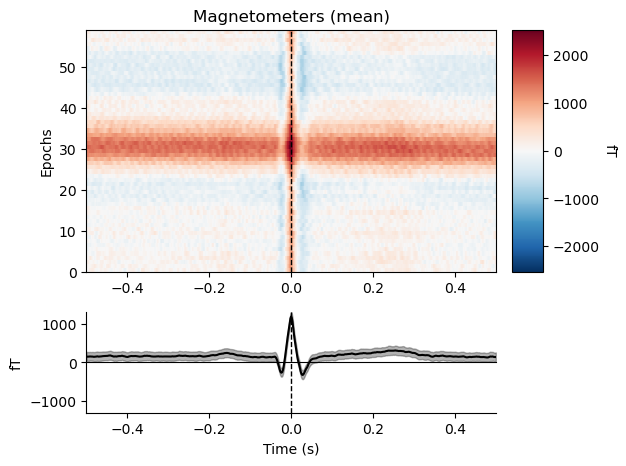

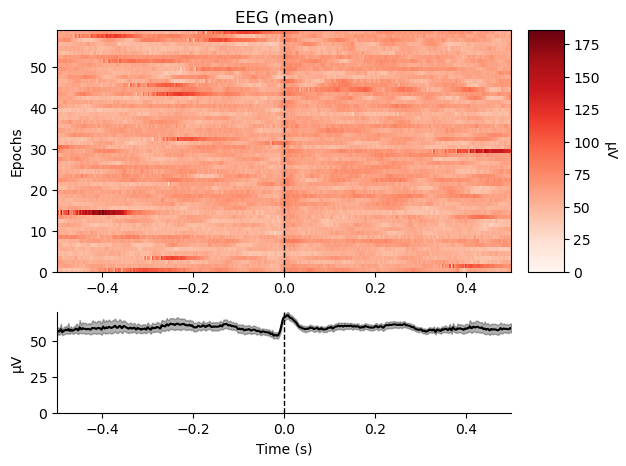

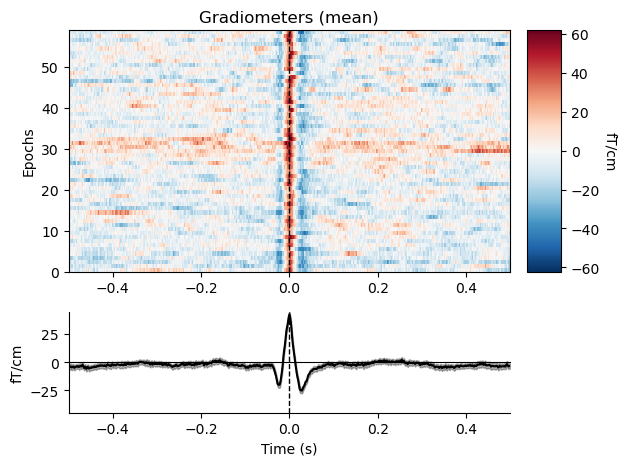

In [7]:
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean');

Applying baseline correction (mode: mean)


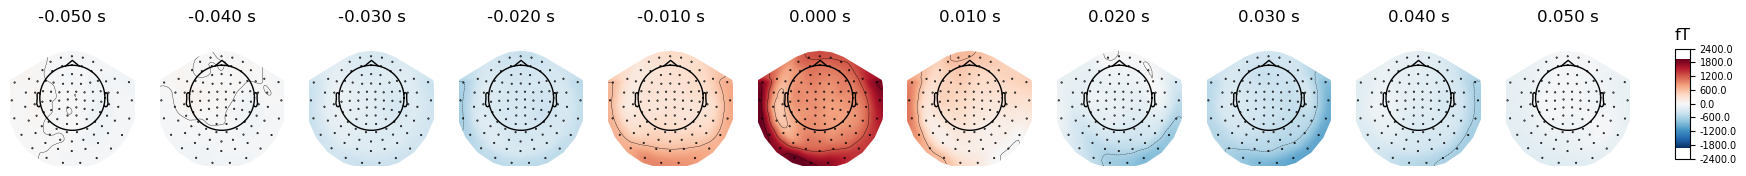

In [10]:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))
avg_ecg_epochs.plot_topomap(times=np.linspace(-0.05, 0.05, 11));

No projector specified for this dataset. Please consider the method self.add_proj.


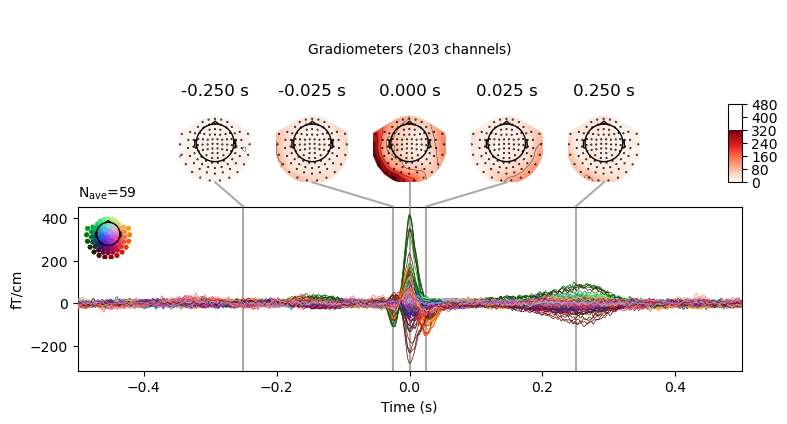

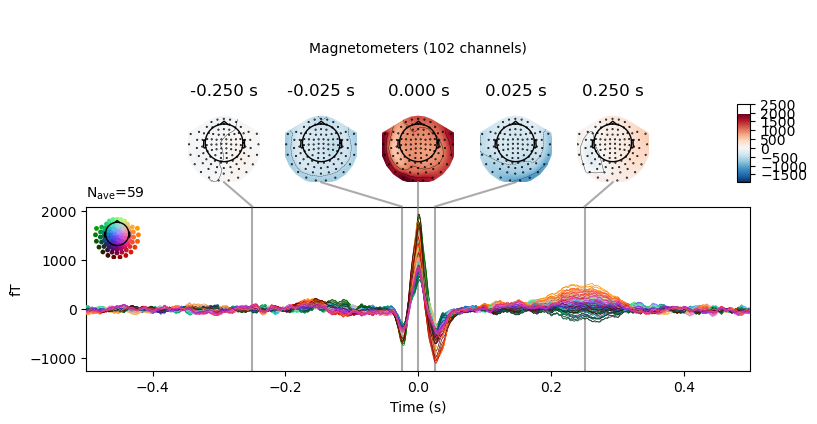

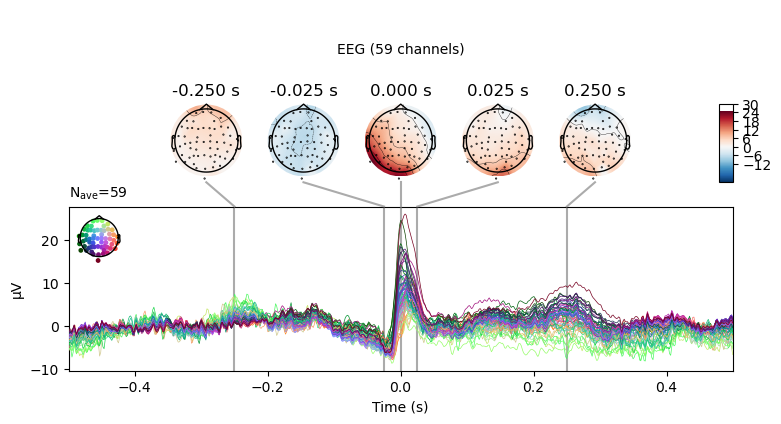

In [11]:
avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25]);

# ocular artifacts(EOG)

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 10 events and 601 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


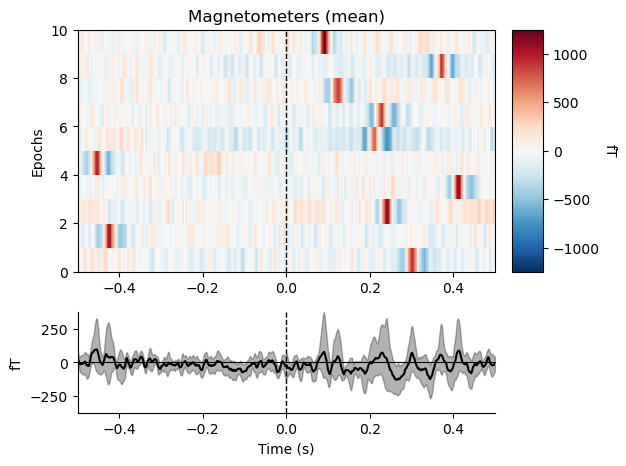

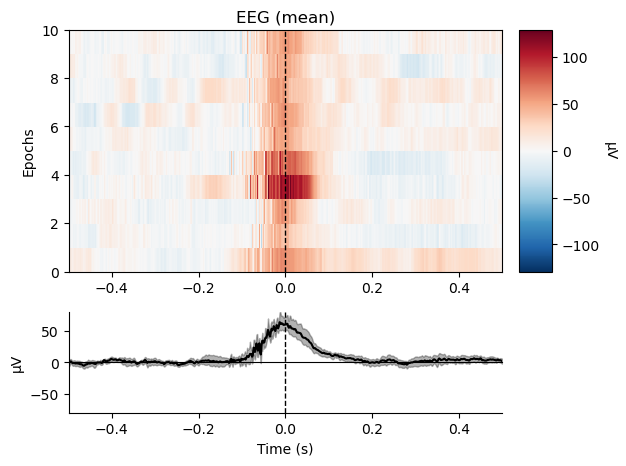

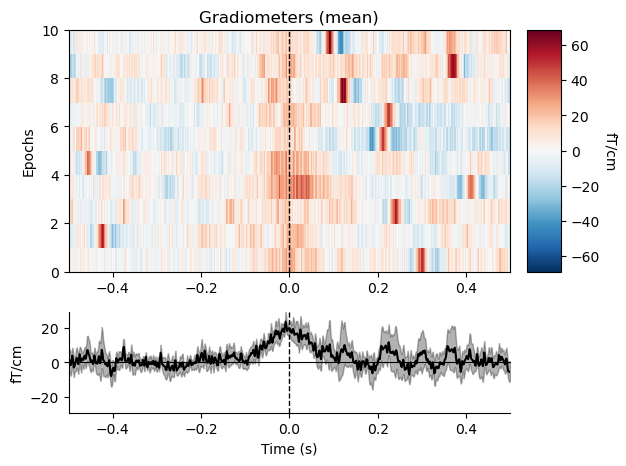

No projector specified for this dataset. Please consider the method self.add_proj.


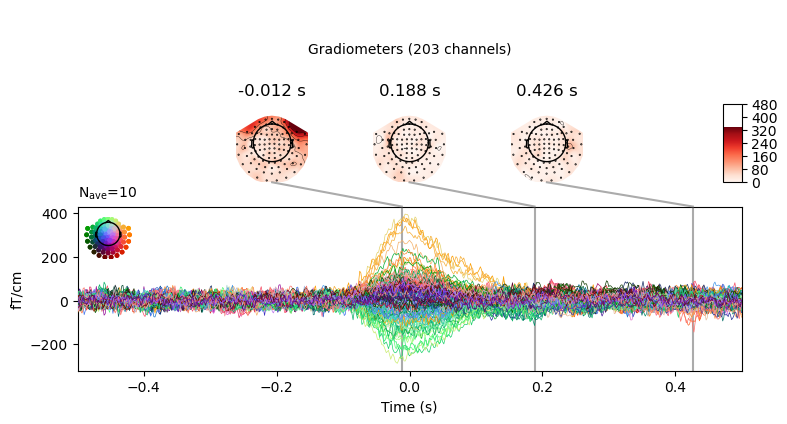

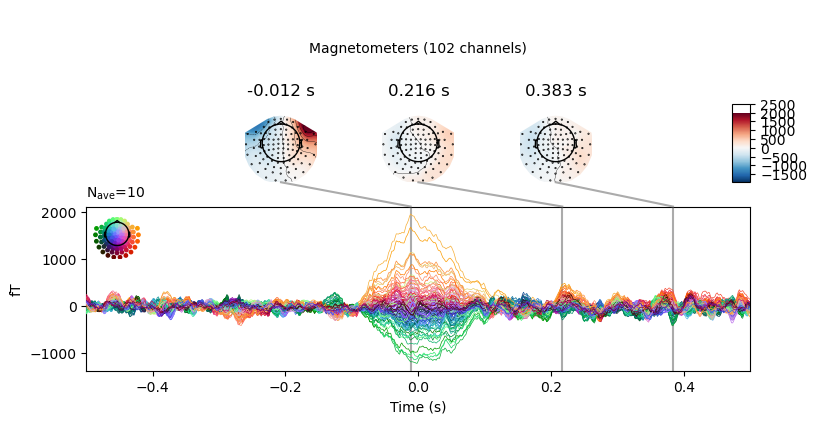

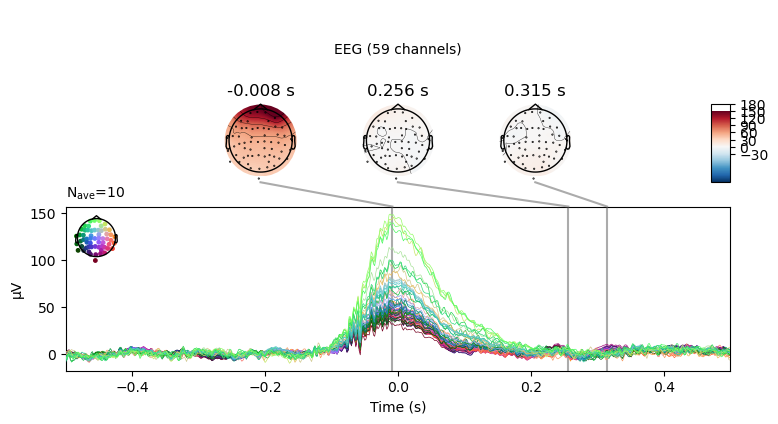

In [12]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint();

In [ ]:
#  A good rule of thumb is that the artifact amplitudes should be orders of magnitude larger than your signal of interest — 
# and there should be several occurrences of such events — 
# in order to find signal decompositions that effectively estimate and repair the artifacts.

# Handling bad channels

In [13]:
print(raw.info['bads'])

['MEG 2443', 'EEG 053']


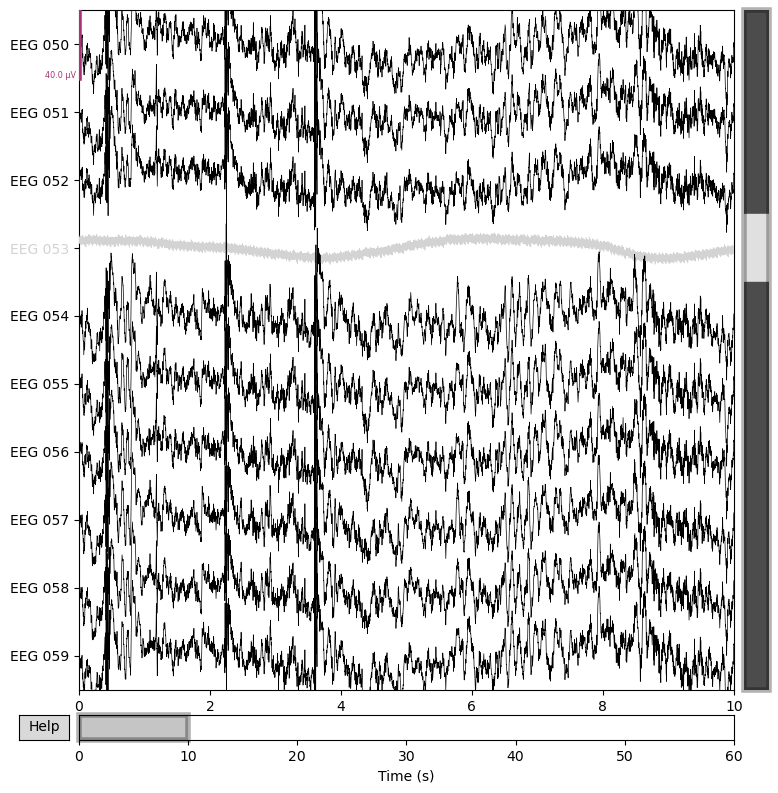

In [14]:
# show the bad channels and good channls
picks = mne.pick_channels_regexp(raw.ch_names, regexp='EEG 05.')
raw.plot(order=picks, n_channels=len(picks));

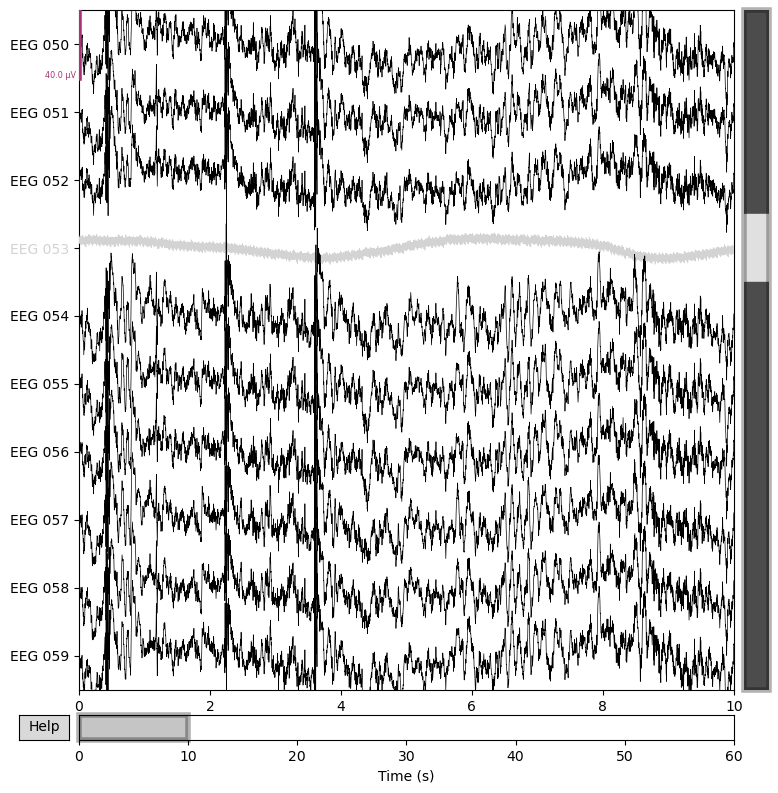

In [15]:
icks = mne.pick_channels_regexp(raw.ch_names, regexp='MEG 2..3')
raw.plot(order=picks, n_channels=len(picks));

In [18]:
original_bads = deepcopy(raw.info['bads'])
raw.info['bads'].append('EEG 050')               # add a single channel
raw.info['bads'].extend(['EEG 051', 'EEG 052'])  # add a list of channels
bad_chan = raw.info['bads'].pop(-1)  # remove the last entry in the list
raw.info['bads'] = original_bads     # change the whole list at once

NameError: name 'deepcopy' is not defined

In [21]:
# default is exclude='bads':
good_eeg = mne.pick_types(raw.info, meg=False, eeg=True)
all_eeg = mne.pick_types(raw.info, meg=False, eeg=True, exclude=[])
print(np.setdiff1d(all_eeg, good_eeg))
print(np.array(raw.ch_names)[np.setdiff1d(all_eeg, good_eeg)])

[367]
['EEG 053']


86 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


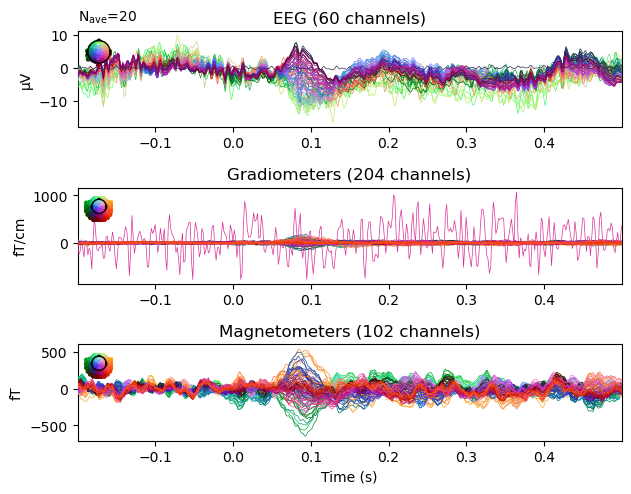

In [22]:
# bad signal invloved 

raw2 = raw.copy()
raw2.info['bads'] = []
events = mne.find_events(raw2, stim_channel='STI 014')
epochs = mne.Epochs(raw2, events=events)['2'].average().plot()

86 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


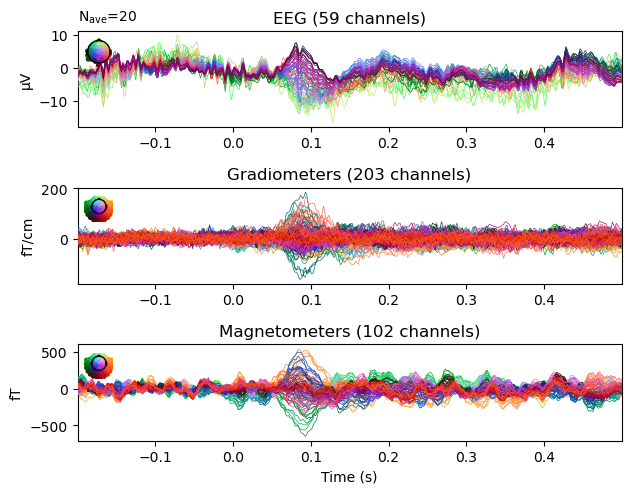

In [26]:
# bad signal remove 

raw2 = raw.copy()
raw2.info['bads'] = ['EEG 053', 'MEG 2443']
events = mne.find_events(raw2, stim_channel='STI 014')
epochs = mne.Epochs(raw2, events=events)['2'].average().plot()

In [27]:
raw.crop(tmin=0, tmax=3).load_data()

<Raw | sample_audvis_raw.fif, 376 x 1803 (3.0 s), ~8.4 MB, data loaded>

# interpolate bad channels

Interpolating bad channels
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors


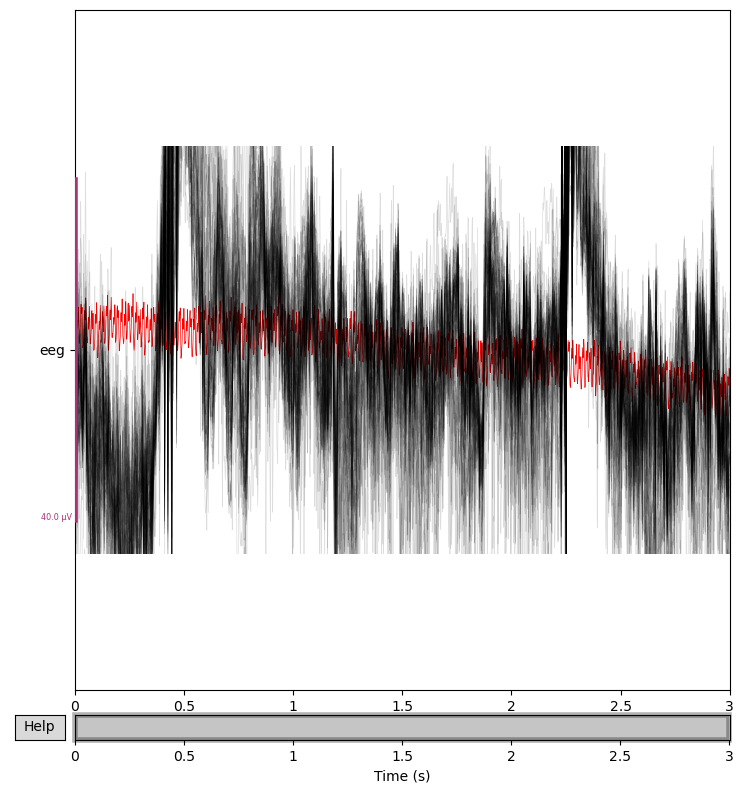

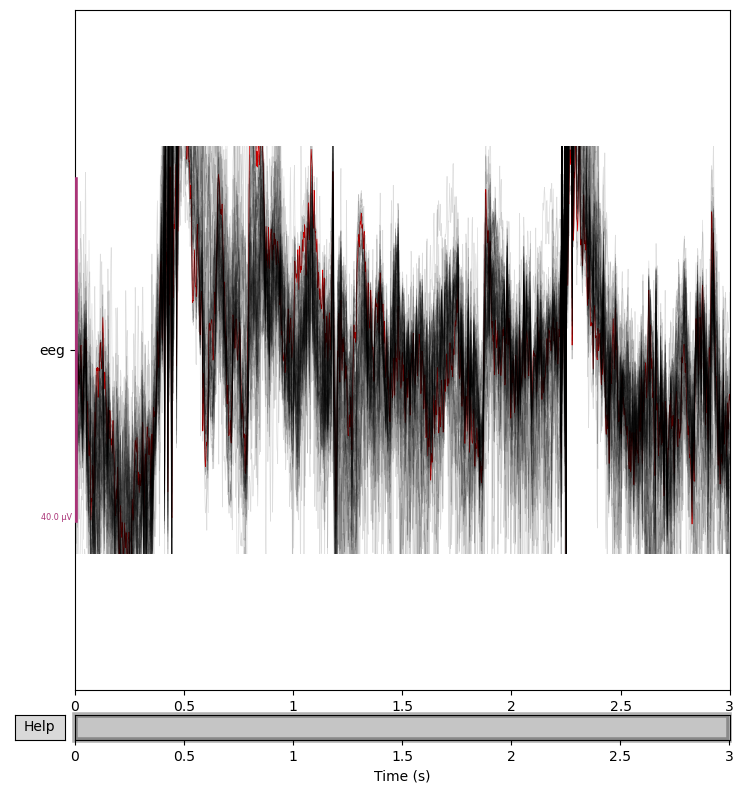

In [28]:
eeg_data = raw.copy().pick_types(meg=False, eeg=True, exclude=[])
eeg_data_interp = eeg_data.copy().interpolate_bads(reset_bads=False)

for title, data in zip(['orig.', 'interp.'], [eeg_data, eeg_data_interp]):
    with mne.viz.use_browser_backend('matplotlib'):
        fig = data.plot(butterfly=True, color='#00000022', bad_color='r')
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title, size='xx-large', weight='bold')

Interpolating bad channels
    Automatic origin fit: head of radius 91.0 mm
    Computing dot products for 203 MEG channels...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Computing cross products for 203 → 1 MEG channel...
    Preparing the mapping matrix...
    Truncating at 84/203 components to omit less than 0.0001 (9.7e-05)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


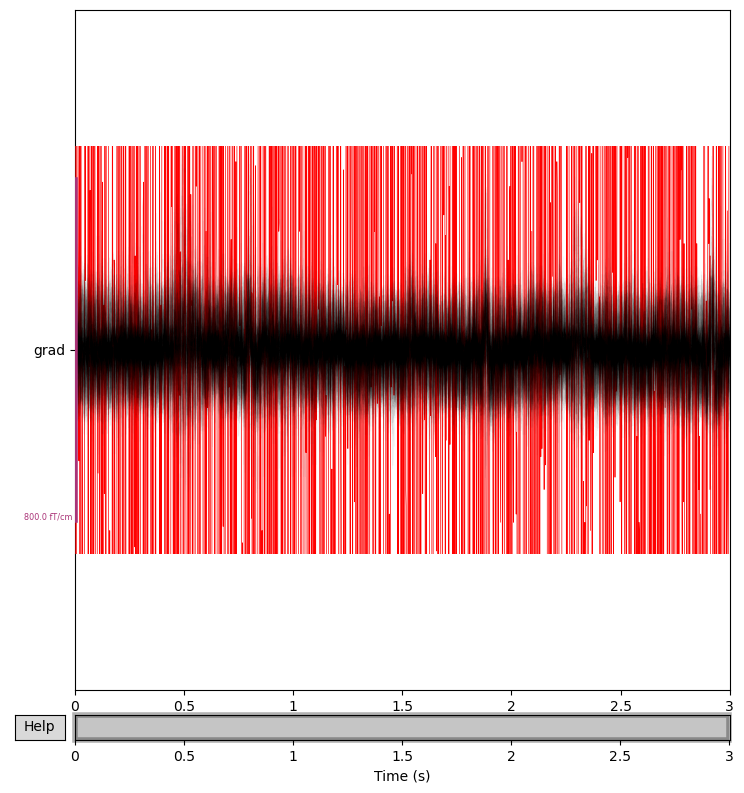

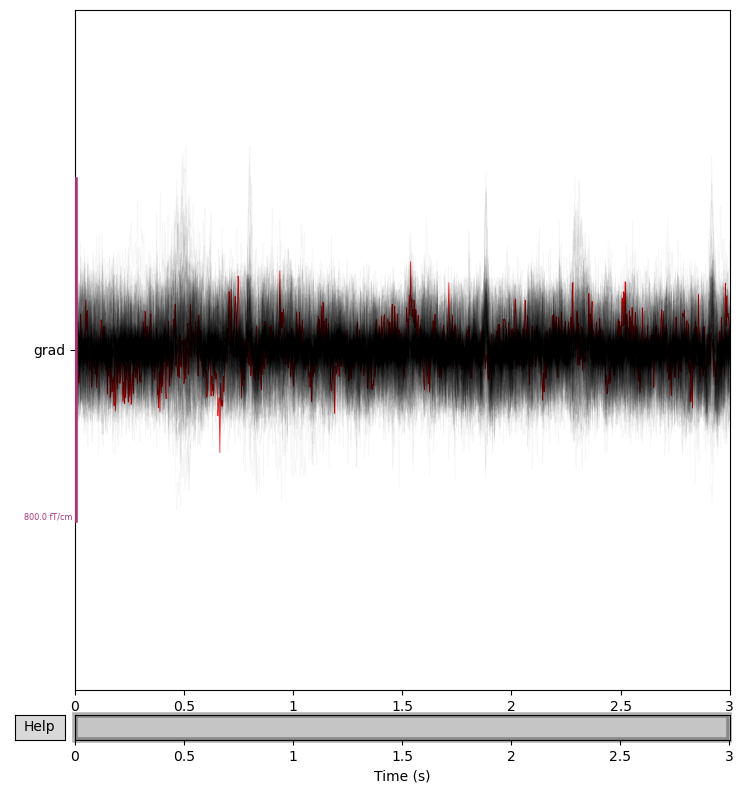

In [29]:
grad_data = raw.copy().pick_types(meg='grad', exclude=[])
grad_data_interp = grad_data.copy().interpolate_bads(reset_bads=False)

for data in (grad_data, grad_data_interp):
    data.plot(butterfly=True, color='#00000009', bad_color='r')

# reject bad data spans and breaks

In [32]:
events

array([[ 6994,     0,     2],
       [ 7086,     0,     3],
       [ 7192,     0,     1],
       [ 7304,     0,     4],
       [ 7413,     0,     2],
       [ 7506,     0,     3],
       [ 7612,     0,     1],
       [ 7709,     0,     4],
       [ 7810,     0,     2],
       [ 7916,     0,     3],
       [ 8025,     0,     1],
       [ 8129,     0,     4],
       [ 8233,     0,     2],
       [ 8331,     0,     3],
       [ 8428,     0,     1],
       [ 8522,     0,     5],
       [ 8633,     0,     2],
       [ 8662,     0,    32],
       [ 8739,     0,     3],
       [ 8857,     0,     1],
       [ 8962,     0,     4],
       [ 9052,     0,     2],
       [ 9144,     0,     3],
       [ 9251,     0,     1],
       [ 9365,     0,     4],
       [ 9477,     0,     2],
       [ 9581,     0,     3],
       [ 9677,     0,     1],
       [ 9782,     0,     4],
       [ 9890,     0,     2],
       [ 9981,     0,     3],
       [10101,     0,     1],
       [10220,     0,     4],
       [10

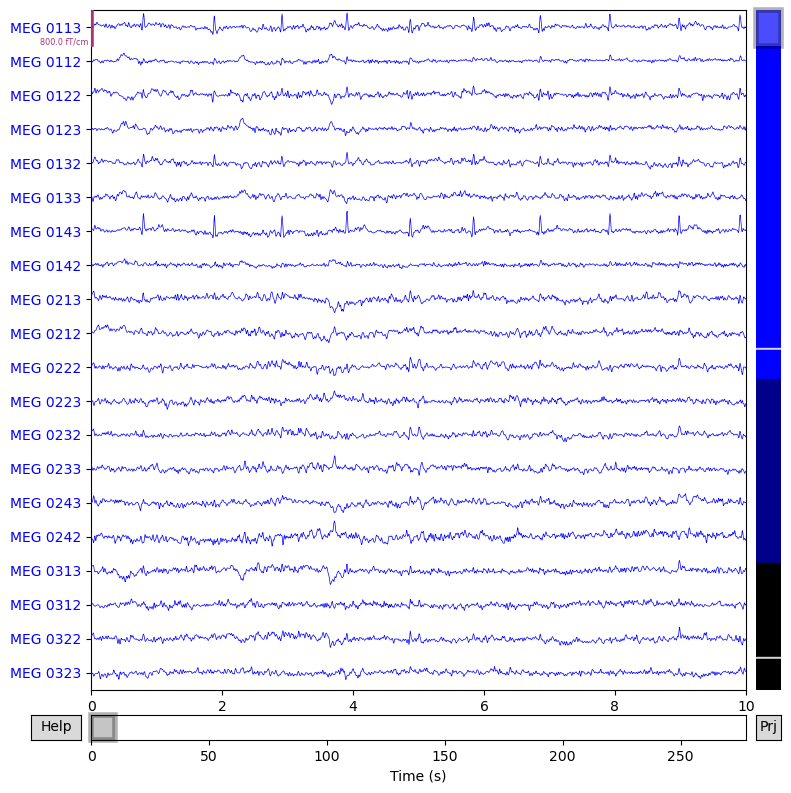

/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [33]:
fig = raw.plot()
fig.fake_keypress('a')  # Simulates user pressing 'a' on the keyboard.

In [34]:
eog_events = mne.preprocessing.find_eog_events(raw)
onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['bad blink'] * len(eog_events)
blink_annot = mne.Annotations(onsets, durations, descriptions,
                              orig_time=raw.info['meas_date'])
raw.set_annotations(blink_annot)

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 sec)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>

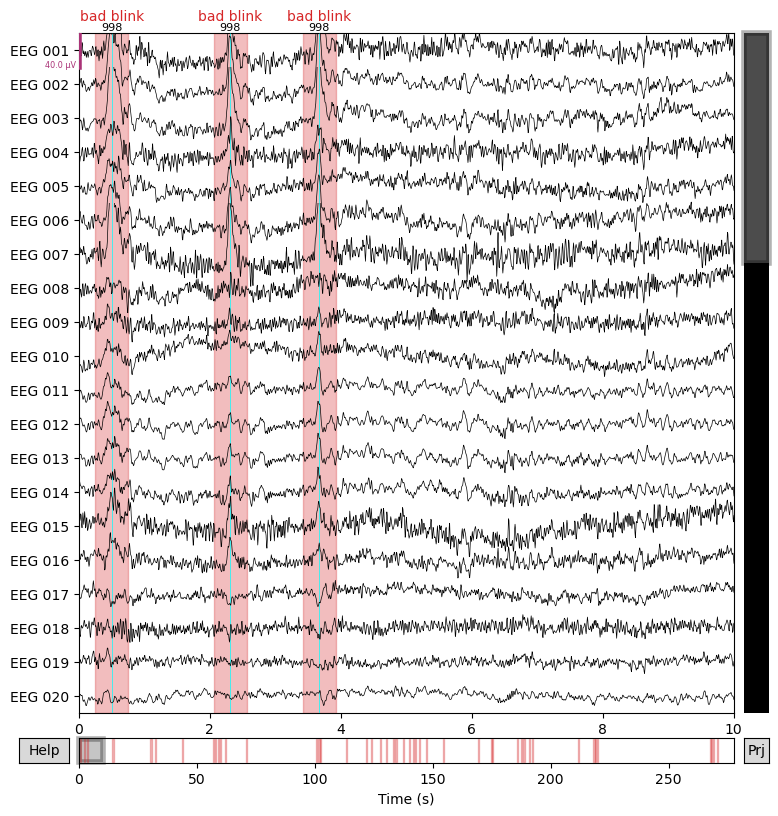

In [36]:
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)
raw.plot(events=eog_events, order=eeg_picks);

# reject epochs based on channel amplitude

In [37]:
reject_criteria = dict(mag=3000e-15,     # 3000 fT
                       grad=3000e-13,    # 3000 fT/cm
                       eeg=100e-6,       # 100 µV
                       eog=200e-6)       # 200 µV

flat_criteria = dict(mag=1e-15,          # 1 fT
                     grad=1e-13,         # 1 fT/cm
                     eeg=1e-6)           # 1 µV

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003']
8 bad epochs dropped


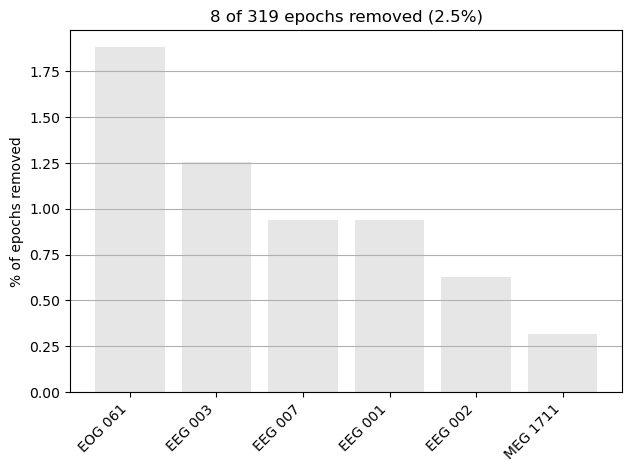

In [39]:
raw.set_annotations(blink_annot)  # restore the EOG annotations
epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.5, reject_tmax=0,
                    reject=reject_criteria, flat=flat_criteria,
                    reject_by_annotation=False, preload=True)
epochs.plot_drop_log();

In [40]:
epochs.drop_bad()

In [41]:
stronger_reject_criteria = dict(mag=2000e-15,     # 2000 fT
                                grad=2000e-13,    # 2000 fT/cm
                                eeg=100e-6,       # 100 µV
                                eog=100e-6)       # 100 µV

epochs.drop_bad(reject=stronger_reject_criteria)
print(epochs.drop_log)

    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1441', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rej

# 滤波基础

In [ ]:
# FIR filters

In [42]:
import numpy as np
from numpy.fft import fft, fftfreq
from scipy import signal
import matplotlib.pyplot as plt

from mne.time_frequency.tfr import morlet
from mne.viz import plot_filter, plot_ideal_filter

import mne

sfreq = 1000.
f_p = 40.
# limits for plotting
flim = (1., sfreq / 2.)  # frequencies
dlim = (-0.2, 0.2)  # delays

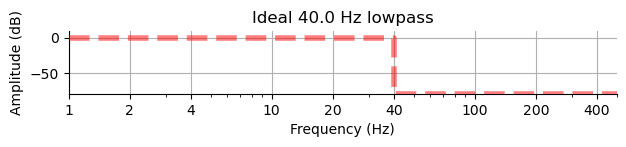

In [44]:
nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

third_height = np.array(plt.rcParams['figure.figsize']) * [1, 1. / 3.]
ax = plt.subplots(1, figsize=third_height)[1]
plot_ideal_filter(freq, gain, ax, title='Ideal %s Hz lowpass' % f_p, flim=flim);

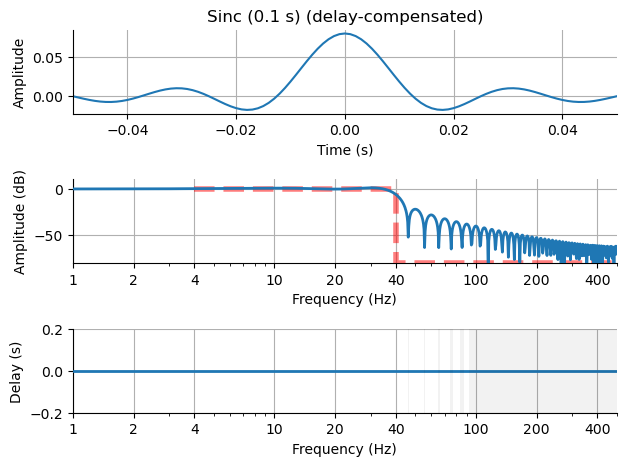

In [47]:
n = int(round(0.1 * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq  # center our sinc
h = np.sinc(2 * f_p * t) / (4 * np.pi)
kwargs = dict(flim=flim, dlim=dlim)
plot_filter(h, sfreq, freq, gain, 'Sinc (0.1 s)', compensate=True, **kwargs);

FIR FITLERS

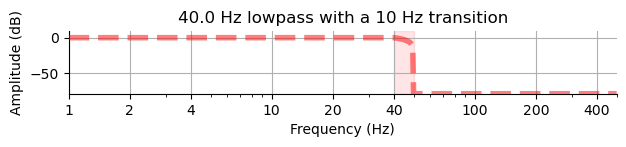

In [52]:
trans_bandwidth = 10  # 10 Hz transition band
f_s = f_p + trans_bandwidth  # = 50 Hz

freq = [0., f_p, f_s, nyq]
gain = [1., 1., 0., 0.]
ax = plt.subplots(1, figsize=third_height)[1]
title = '%s Hz lowpass with a %s Hz transition' % (f_p, trans_bandwidth)
plot_ideal_filter(freq, gain, ax, title=title, flim=flim);

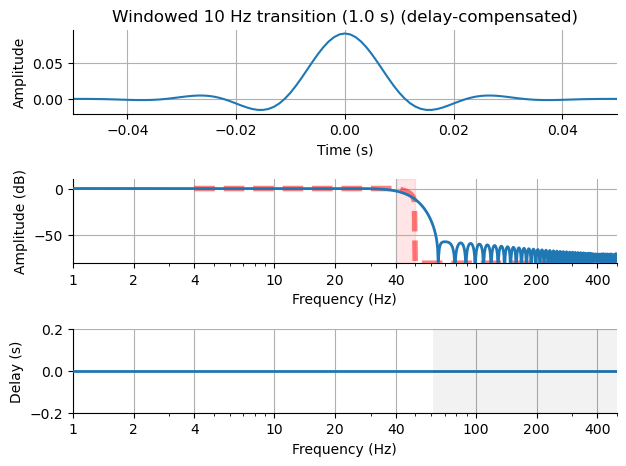

In [54]:
h = signal.firwin2(n, freq, gain, fs=sfreq)
plot_filter(h, sfreq, freq, gain, 'Windowed 10 Hz transition (1.0 s)',
            compensate=True, **kwargs);

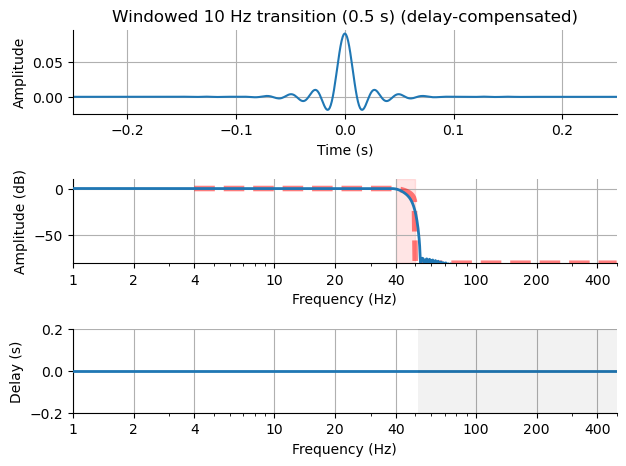

In [55]:
n = int(round(sfreq * 0.5)) + 1
h = signal.firwin2(n, freq, gain, fs=sfreq)
plot_filter(h, sfreq, freq, gain, 'Windowed 10 Hz transition (0.5 s)',
            compensate=True, **kwargs);

# applying FIR filters

In [56]:
dur = 10.
center = 2.
morlet_freq = f_p
tlim = [center - 0.2, center + 0.2]
tticks = [tlim[0], center, tlim[1]]
flim = [20, 70]

x = np.zeros(int(sfreq * dur) + 1)
blip = morlet(sfreq, [morlet_freq], n_cycles=7)[0].imag / 20.
n_onset = int(center * sfreq) - len(blip) // 2
x[n_onset:n_onset + len(blip)] += blip
x_orig = x.copy()

rng = np.random.RandomState(0)
x += rng.randn(len(x)) / 1000.
x += np.sin(2. * np.pi * 60. * np.arange(len(x)) / sfreq) / 2000.

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



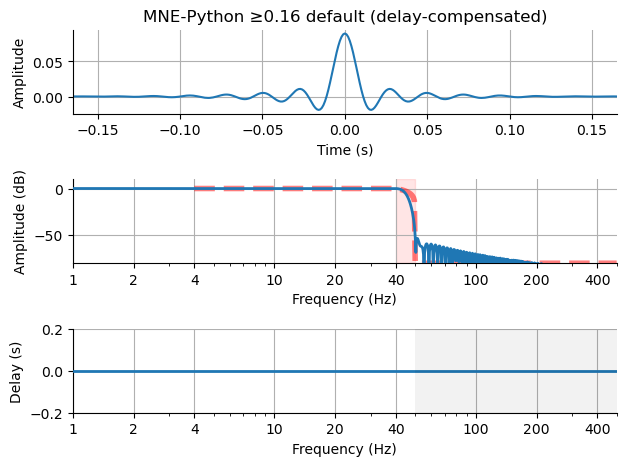

In [57]:
transition_band = 0.25 * f_p
f_s = f_p + transition_band
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
# This would be equivalent:
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             fir_design='firwin', verbose=True)
x_v16 = np.convolve(h, x)
# this is the linear->zero phase, causal-to-non-causal conversion / shift
x_v16 = x_v16[len(h) // 2:]

plot_filter(h, sfreq, freq, gain, 'MNE-Python ≥0.16 default',
            compensate=True, **kwargs);

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (0.661 sec)



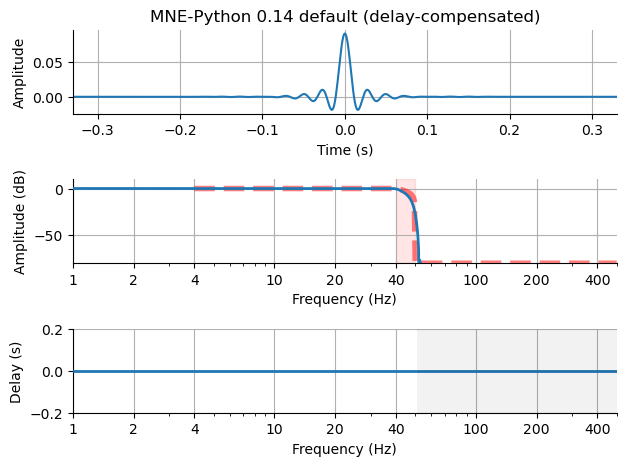

In [58]:
# filter with a diffrerent method fir_design - firwin2

transition_band = 0.25 * f_p
f_s = f_p + transition_band
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
# This would be equivalent:
# filter_dur = 6.6 / transition_band  # sec
# n = int(sfreq * filter_dur)
# h = signal.firwin2(n, freq, gain, nyq=sfreq / 2.)
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             fir_design='firwin2', verbose=True)
x_v14 = np.convolve(h, x)[len(h) // 2:]

plot_filter(h, sfreq, freq, gain, 'MNE-Python 0.14 default',
            compensate=True, **kwargs);

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 40.25 Hz)
- Filter length: 10001 samples (10.001 sec)



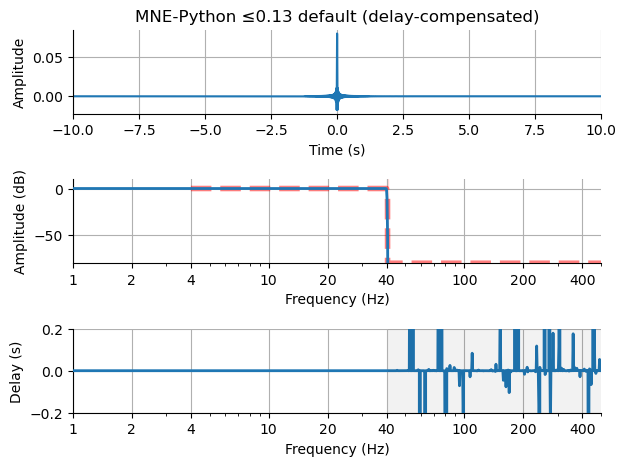

In [59]:
# filter with mne-python 0.13 defualt long-duration, steep cutoff fir
transition_band = 0.5  # Hz
f_s = f_p + transition_band
filter_dur = 10.  # sec
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
# This would be equivalent
# n = int(sfreq * filter_dur)
# h = signal.firwin2(n, freq, gain, nyq=sfreq / 2.)
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             h_trans_bandwidth=transition_band,
                             filter_length='%ss' % filter_dur,
                             fir_design='firwin2', verbose=True)
x_v13 = np.convolve(np.convolve(h, x)[::-1], h)[::-1][len(h) - 1:-len(h) - 1]
# the effective h is one that is applied to the time-reversed version of itself
h_eff = np.convolve(h, h[::-1])
plot_filter(h_eff, sfreq, freq, gain, 'MNE-Python ≤0.13 default',
            compensate=True, **kwargs);

filter :   0.000 ...   42.5 Hz   bins : 0 ... 348 of 4097 hpw : 3 lpw : 20


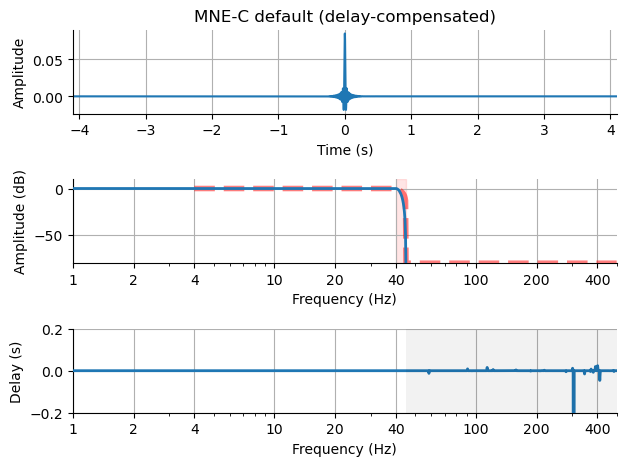

In [62]:
# filtere iwth MNE-C default long -duration, steep slope FRI filter

h = mne.filter.design_mne_c_filter(sfreq, l_freq=None, h_freq=f_p + 2.5)
x_mne_c = np.convolve(h, x)[len(h) // 2:]

transition_band = 5  # Hz (default in MNE-C)
f_s = f_p + transition_band
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
plot_filter(h, sfreq, freq, gain, 'MNE-C default', compensate=True, **kwargs);

# minimu-phase filter,

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper transition bandwidth: 10.00 Hz
- Filter length: 331 samples (0.331 sec)



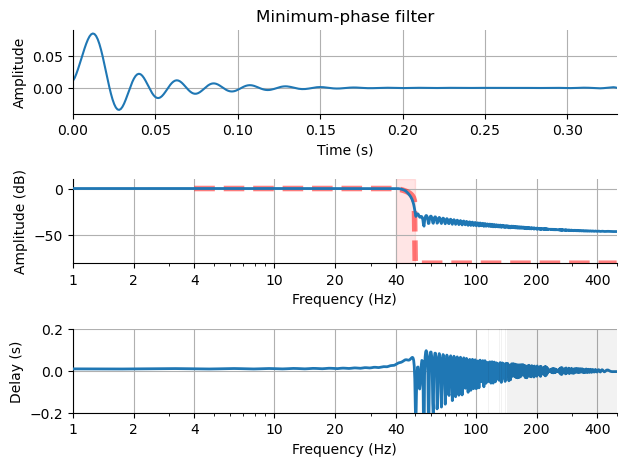

In [63]:
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             phase='minimum', fir_design='firwin',
                             verbose=True)
x_min = np.convolve(h, x)
transition_band = 0.25 * f_p
f_s = f_p + transition_band
filter_dur = 6.6 / transition_band  # sec
n = int(sfreq * filter_dur)
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
plot_filter(h, sfreq, freq, gain, 'Minimum-phase filter', **kwargs);

Both the MNE-Python 0.13 and MNE-C filters have excellent frequency attenuation

Ringing can occur with steep filters, especially in signals with frequency content around the transition band. Our Morlet wavelet signal has power in our transition band, and the time-domain ringing is thus more pronounced for the steep-slope, long-duration filter than the shorter, shallower-slope filter:

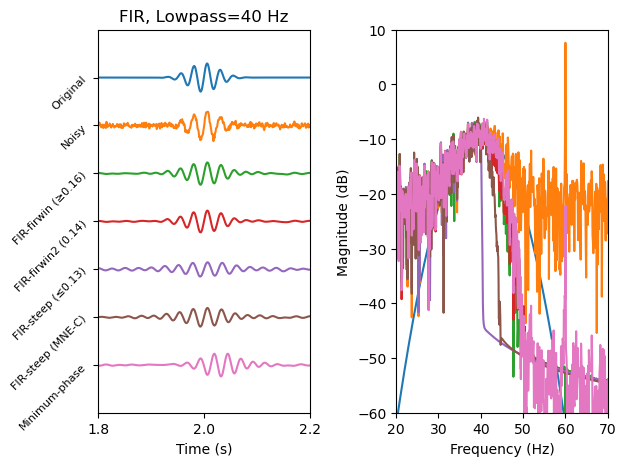

In [64]:
axes = plt.subplots(1, 2)[1]


def plot_signal(x, offset):
    """Plot a signal."""
    t = np.arange(len(x)) / sfreq
    axes[0].plot(t, x + offset)
    axes[0].set(xlabel='Time (s)', xlim=t[[0, -1]])
    X = fft(x)
    freqs = fftfreq(len(x), 1. / sfreq)
    mask = freqs >= 0
    X = X[mask]
    freqs = freqs[mask]
    axes[1].plot(freqs, 20 * np.log10(np.maximum(np.abs(X), 1e-16)))
    axes[1].set(xlim=flim)


yscale = 30
yticklabels = ['Original', 'Noisy', 'FIR-firwin (≥0.16)', 'FIR-firwin2 (0.14)',
               'FIR-steep (≤0.13)', 'FIR-steep (MNE-C)', 'Minimum-phase']
yticks = -np.arange(len(yticklabels)) / yscale
plot_signal(x_orig, offset=yticks[0])
plot_signal(x, offset=yticks[1])
plot_signal(x_v16, offset=yticks[2])
plot_signal(x_v14, offset=yticks[3])
plot_signal(x_v13, offset=yticks[4])
plot_signal(x_mne_c, offset=yticks[5])
plot_signal(x_min, offset=yticks[6])
axes[0].set(xlim=tlim, title='FIR, Lowpass=%d Hz' % f_p, xticks=tticks,
            ylim=[-len(yticks) / yscale, 1. / yscale],
            yticks=yticks, yticklabels=yticklabels)
for text in axes[0].get_yticklabels():
    text.set(rotation=45, size=8)
axes[1].set(xlim=flim, ylim=(-60, 10), xlabel='Frequency (Hz)',
            ylabel='Magnitude (dB)')
mne.viz.tight_layout()
plt.show()

# IIR filters

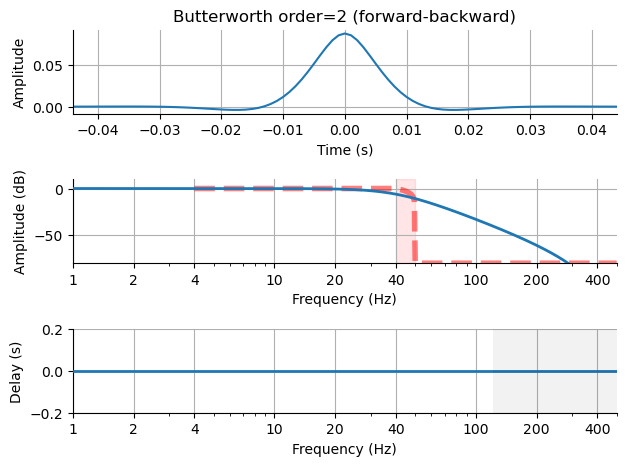

In [65]:
sos = signal.iirfilter(2, f_p / nyq, btype='low', ftype='butter', output='sos')
plot_filter(dict(sos=sos), sfreq, freq, gain, 'Butterworth order=2',
            compensate=True, **kwargs)
x_shallow = signal.sosfiltfilt(sos, x)
del sos

Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



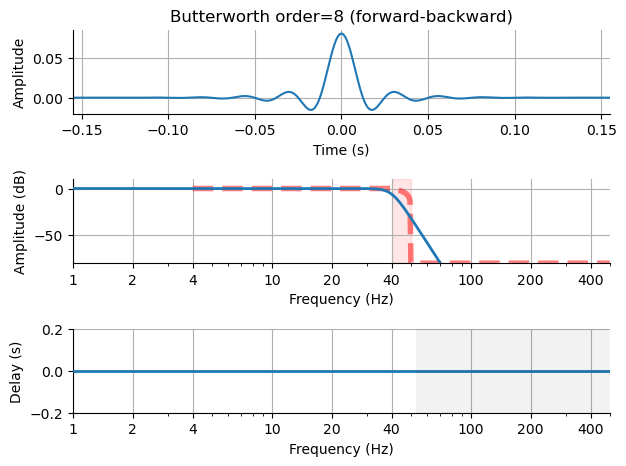

In [66]:
iir_params = dict(order=8, ftype='butter')
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain, 'Butterworth order=8',
            compensate=True, **kwargs)
x_steep = signal.sosfiltfilt(filt['sos'], x)

Chebychev (type I) filter

Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Chebyshev I lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -2.00 dB



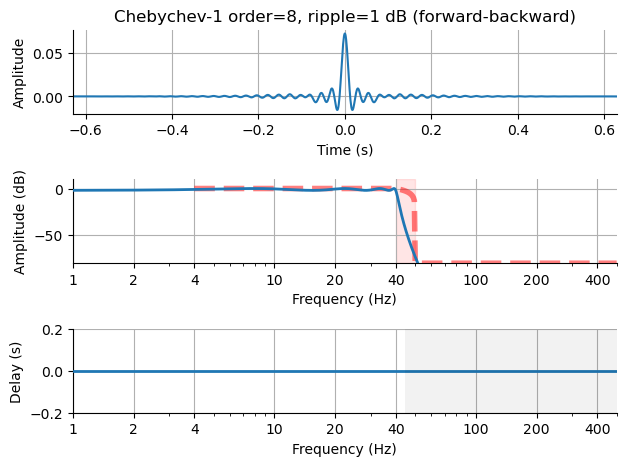

In [68]:
iir_params.update(ftype='cheby1',
                  rp=1.,  # dB of acceptable pass-band ripple
                  )
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain, 'Chebychev-1 order=8, ripple=1 dB',
            compensate=True, **kwargs);

Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Chebyshev I lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -12.00 dB



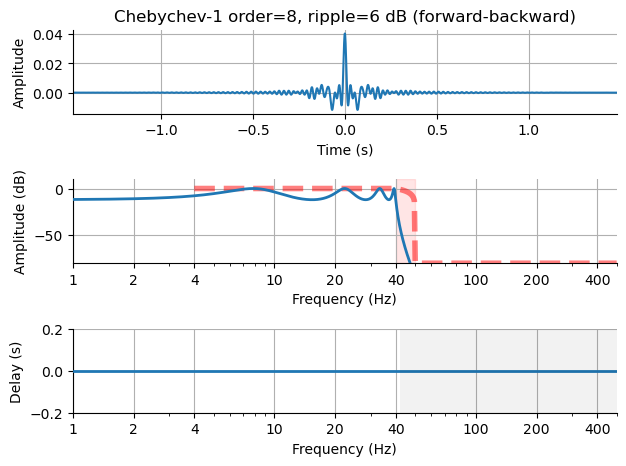

In [69]:
iir_params['rp'] = 6.
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain, 'Chebychev-1 order=8, ripple=6 dB',
            compensate=True, **kwargs);

# Applying IIR filters

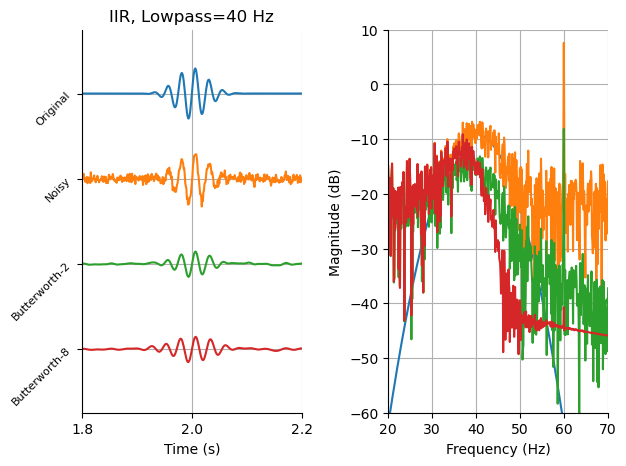

In [70]:
axes = plt.subplots(1, 2)[1]
yticks = np.arange(4) / -30.
yticklabels = ['Original', 'Noisy', 'Butterworth-2', 'Butterworth-8']
plot_signal(x_orig, offset=yticks[0])
plot_signal(x, offset=yticks[1])
plot_signal(x_shallow, offset=yticks[2])
plot_signal(x_steep, offset=yticks[3])
axes[0].set(xlim=tlim, title='IIR, Lowpass=%d Hz' % f_p, xticks=tticks,
            ylim=[-0.125, 0.025], yticks=yticks, yticklabels=yticklabels,)
for text in axes[0].get_yticklabels():
    text.set(rotation=45, size=8)
axes[1].set(xlim=flim, ylim=(-60, 10), xlabel='Frequency (Hz)',
            ylabel='Magnitude (dB)')
mne.viz.adjust_axes(axes)
mne.viz.tight_layout()
plt.show()